# Audio Preprocessor — Debug Analysis

Visually compares raw vs. band-pass filtered audio.

**Before running:** generate the files with:
```bash
python python/main.py --mode file --input Audio/test_1.wav --debug-audio
```
This writes `debug_raw.wav` and `debug_filtered.wav` in the project root.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wavfile
from scipy.signal import spectrogram

sr_raw,  raw      = wavfile.read('debug_raw.wav')
sr_filt, filtered = wavfile.read('debug_filtered.wav')

# Normalise to float32 [-1, 1] regardless of bit depth
def to_float(x):
    if x.dtype == np.float32:
        return x
    return x.astype(np.float32) / np.iinfo(x.dtype).max

raw      = to_float(raw)
filtered = to_float(filtered)

print(f'Raw      : {len(raw)/sr_raw:.2f}s  @{sr_raw} Hz')
print(f'Filtered : {len(filtered)/sr_filt:.2f}s  @{sr_filt} Hz')

Raw      : 3.00s  @16000 Hz
Filtered : 3.00s  @16000 Hz


## 1 — Waveform (time domain)

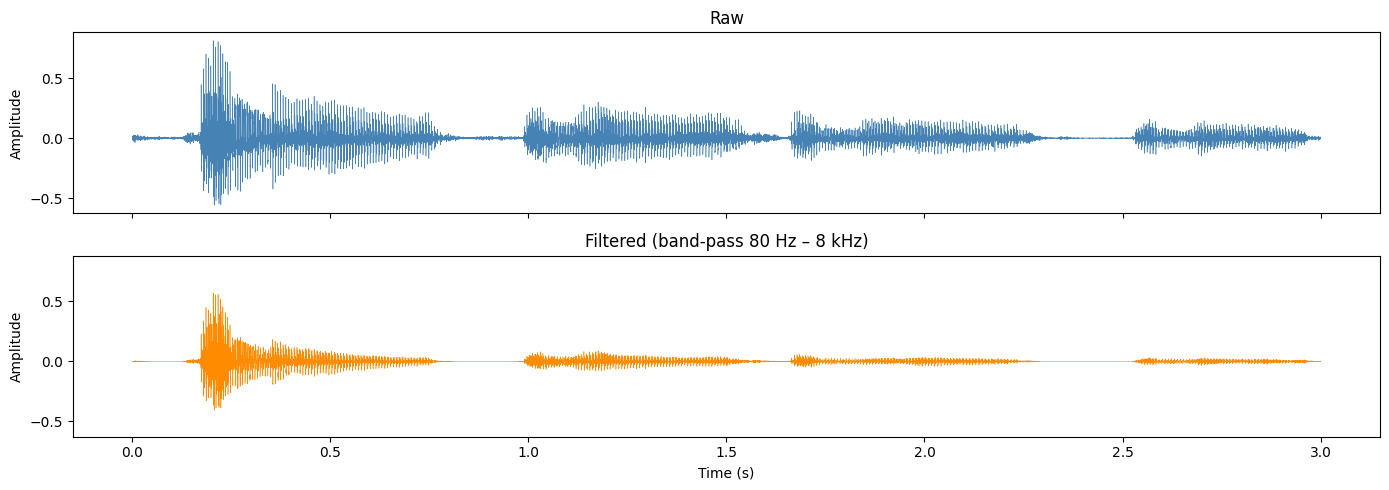

In [2]:
t_raw  = np.arange(len(raw))  / sr_raw
t_filt = np.arange(len(filtered)) / sr_filt

fig, axes = plt.subplots(2, 1, figsize=(14, 5), sharex=True, sharey=True)
axes[0].plot(t_raw,  raw,      color='steelblue', linewidth=0.4)
axes[0].set_title('Raw')
axes[1].plot(t_filt, filtered, color='darkorange', linewidth=0.4)
axes[1].set_title('Filtered (band-pass 80 Hz – 8 kHz)')
for ax in axes:
    ax.set_ylabel('Amplitude')
axes[1].set_xlabel('Time (s)')
fig.tight_layout()
plt.show()

## 2 — Frequency spectrum (FFT magnitude)

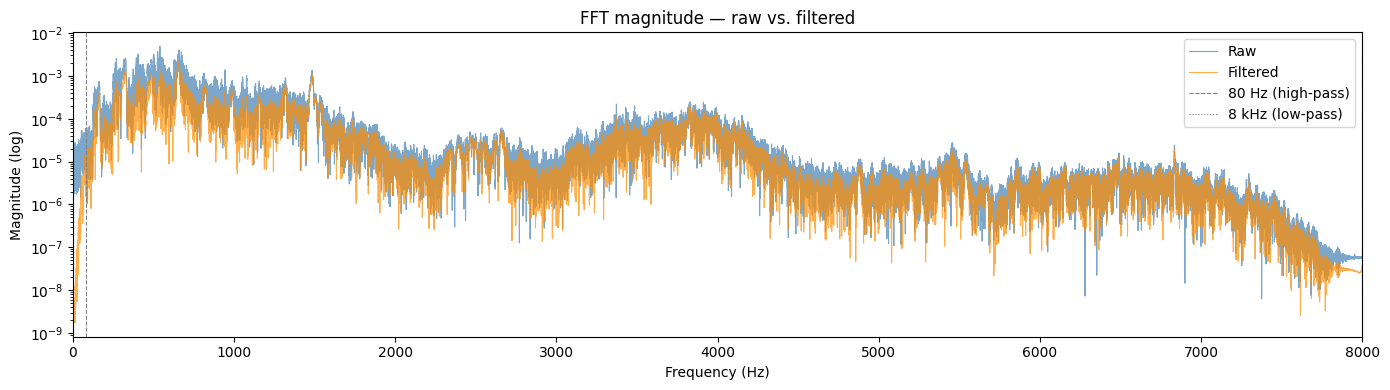

In [3]:
def fft_mag(signal, sr):
    n    = len(signal)
    mag  = np.abs(np.fft.rfft(signal)) / n
    freq = np.fft.rfftfreq(n, d=1/sr)
    return freq, mag

freq_r, mag_r = fft_mag(raw,      sr_raw)
freq_f, mag_f = fft_mag(filtered, sr_filt)

fig, ax = plt.subplots(figsize=(14, 4))
ax.semilogy(freq_r, mag_r, color='steelblue',   alpha=0.7, linewidth=0.8, label='Raw')
ax.semilogy(freq_f, mag_f, color='darkorange',  alpha=0.7, linewidth=0.8, label='Filtered')
ax.axvline(80,   color='gray', linestyle='--', linewidth=0.8, label='80 Hz (high-pass)')
ax.axvline(8000, color='gray', linestyle=':',  linewidth=0.8, label='8 kHz (low-pass)')
ax.set_xlim(0, sr_raw / 2)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Magnitude (log)')
ax.set_title('FFT magnitude — raw vs. filtered')
ax.legend()
fig.tight_layout()
plt.show()

## 3 — Spectrogram (time × frequency)

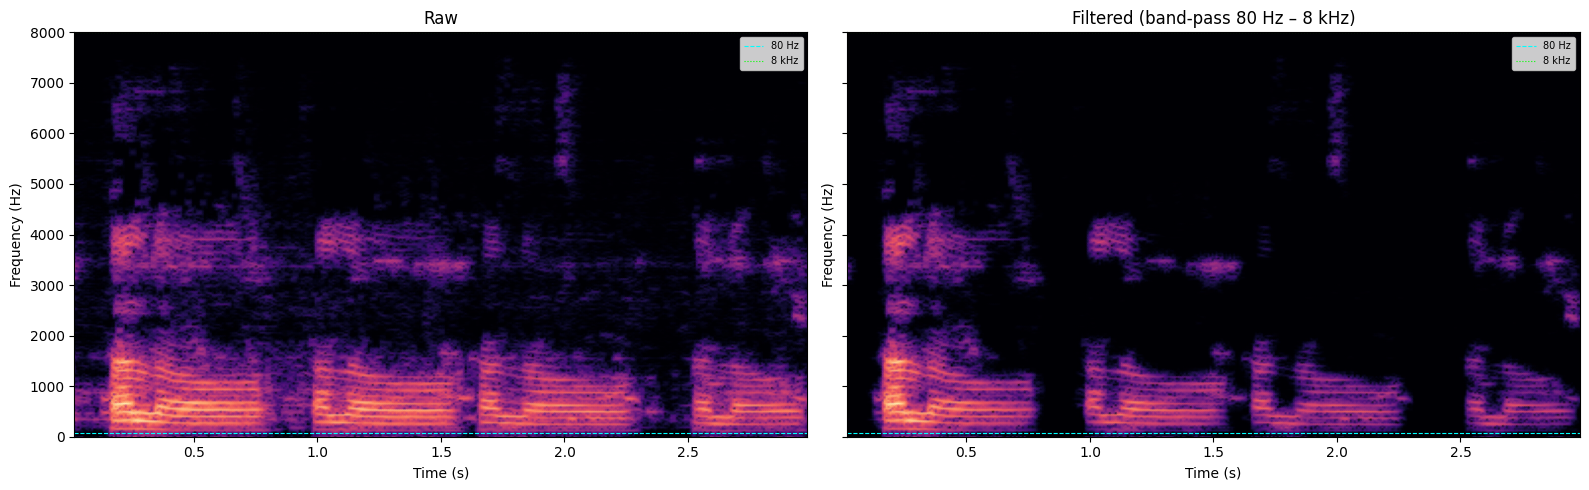

In [4]:
def plot_spectrogram(ax, signal, sr, title):
    f, t, Sxx = spectrogram(signal, fs=sr, nperseg=512, noverlap=384)
    ax.pcolormesh(t, f, 10 * np.log10(Sxx + 1e-10), shading='gouraud', cmap='magma')
    ax.axhline(80,   color='cyan', linestyle='--', linewidth=0.8, label='80 Hz')
    ax.axhline(8000, color='lime', linestyle=':',  linewidth=0.8, label='8 kHz')
    ax.set_ylim(0, sr / 2)
    ax.set_ylabel('Frequency (Hz)')
    ax.set_xlabel('Time (s)')
    ax.set_title(title)
    ax.legend(loc='upper right', fontsize=7)

fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True)
plot_spectrogram(axes[0], raw,      sr_raw,  'Raw')
plot_spectrogram(axes[1], filtered, sr_filt, 'Filtered (band-pass 80 Hz – 8 kHz)')
fig.tight_layout()
plt.show()